# OpenOrca-SlimOrca:

<u>Authors</u>:

*   **Ricci Alessandro** [10931743]
*   **Sanguineti Andrea** [10739788]
*   **Scroccarello Francesco** [10723028]


This notebook contains our project for the Natural Language Course, a.y. 2023-2024, prof. Mark James Carman. It involved the fine tuning of a language model to emulate the behaviour of ChatGPT using a dataset of recorded interactions between a user and the chatbot, applying some of the techniques learnt in the course. The work is based on the paper: [Orca: Progressive Learning from Complex
Explanation Traces of GPT-4](https://arxiv.org/pdf/2306.02707).

<u>Disclaimer</u>: in order to be able to run this notebook properly it is necessary to have an environment with a minimum CUDA capability of 7.0, i.e. 2018+ GPUs (V100, T4, Titan V, RTX 20, 30, 40x, A100, H100, L40 etc), otherwise some of the portions of code requiring unslothAI framework won't run.

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

path = 'NLP-project'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/1eK7-d-rbCS9Rd53xBy5-f8u_TwX5Cb_b/NLP-project'

# Install and import all the required packages

In [ ]:
%%capture
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes
!pip install ffmpeg-python

In [ ]:
import re
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk, load_metric

In [ ]:
from torch import nn, optim
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, GPT2TokenizerFast, TextStreamer, AutoModel, AutoTokenizer

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
from unsloth import FastLanguageModel
from trl import SFTTrainer
from unsloth import is_bfloat16_supported

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


# Utils

Dynamically decides what device to set based on the runtime availability (make sure you're using a CUDA device, otherwise you can only perform exploratory tasks).

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Get audio from microphone

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
old_audio = document.getElementById('audio');
old_audio_player = document.getElementById('audio_player');
if(old_audio){
  old_audio.remove();
}
if(old_audio_player){
  old_audio_player.remove();
}
var my_div = document.createElement("DIV");
my_div.id = "audio";
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    preview.id = "audio_player";
    // document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

# Data Load


The dataset is publicly accessible and downloadable as an instance of the Dataset class. All the details are contained in the corresponding hugging face webpage: https://huggingface.co/datasets/Open-Orca/SlimOrca


In [ ]:
dataset = load_dataset("Open-Orca/SlimOrca", split="train")

We explored a bit the structure of the dataset.

In [ ]:
dataset

Dataset({
    features: ['conversations'],
    num_rows: 517982
})

Each conversation is composed by a system message followed by a human message and the gpt's reponse

In [ ]:
dataset[0]

{'conversations': [{'from': 'system',
   'value': 'You are an AI assistant. You will be given a task. You must generate a detailed and long answer.',
   'weight': None},
  {'from': 'human',
   'value': 'Write an article based on this "A man has been charged with murder and attempted murder after a woman and the man she was on a date with were stabbed at a restaurant in Sydney, Australia."',
   'weight': 0.0},
  {'from': 'gpt',
   'value': "Title: Tragedy Strikes in Sydney: Victims Stabbed during Dinner Date, Suspect Charged with Murder and Attempted Murder\n\nIntroduction\n\nA seemingly ordinary evening took a tragic turn in Sydney, Australia when a romantic dinner date at a local restaurant ended in bloodshed, as a man allegedly attacked a couple, stabbing both victims. Local authorities have charged the suspect with murder and attempted murder in connection with the horrific crime. In this article, we delve into the chilling incident, the suspect, and the impact it has had on the com

We decided to convert the dataset into a Pandas DataFrame in order to be able to manage it easily without filling the entire colab's ram.

In [ ]:
# create a dataframe from the dataset
df = pd.DataFrame(dataset['conversations'])

# extract and separate messages in the 3 categories, in this dataset sometimes the system message is missing, and the human, gpt columns are shifted as first and second leaving the third with a None value
system = df.apply(lambda row: "" if pd.isna(row[2]) else row[0]["value"], axis=1)
human = df.apply(lambda row: row[0]["value"] if pd.isna(row[2]) else row[1]["value"], axis=1)
gpt = df.apply(lambda row: row[1]["value"] if pd.isna(row[2]) else row[2]["value"], axis=1)

# Data Exploration


As written in the [paper](https://arxiv.org/pdf/2306.02707), the dataset is composed of tuples in the form (system messages, human questions, gpt-based responses). Regarding the last 2, they can be arbitrary strings, while system messages are predefined prompts to enrich model training. Just for completeness we report them here:

0: " "

**1: "You are an AI assistant. Provide a detailed answer so user don't need to search outside to understand the answer."**
   
2: "You are an AI assistant. You will be given a task. You must generate a detailed and long answer."

**3: "You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old."**

**4: "You are an AI assistant that follows instruction extremely well. Help as much as you can."**

5: "You are an AI assistant that helps people find information. Provide a detailed answer so user don't need to search outside to understand the answer."

6: "You are an AI assistant. User will you give you a task. Your goal is to complete the task as faithfully as you can. While performing the task think step-by-step and justify your steps."

7: "You should describe the task and explain your answer. While answering a multiple choice question, first output the correct answer(s). Then explain why other answers are wrong. Think like you are answering to a five year old."

8: "Explain how you used the definition to come up with the answer."

9: "You are an AI assistant. You should describe the task and explain your answer. While answering a multiple choice question, first output the correct answer(s). Then explain why other answers are wrong. You might need to use additional knowledge to answer the question."

10: "You are an AI assistant that helps people find information. User will you give you a question. Your task is to answer as faithfully as you can. While answering think step-by-step and justify your answer."

11: "User will you give you a task with some instruction. Your job is follow the instructions as faithfully as you can. While answering think step-by-step and justify your answer."

**12: "You are a teacher. Given a task, you explain in simple steps what the task is asking, any guidelines it provides and how to use those guidelines to find the answer."**

13: "You are an AI assistant, who knows every language and how to translate one language to another. Given a task, you explain in simple steps what the task is asking, any guidelines that it provides. You solve the task and show how you used the guidelines to solve the task."

14: "Given a definition of a task and a sample input, break the definition into small parts.\nEach of those parts will have some instruction. Explain their meaning by showing an example that meets the criteria in the instruction. Use the following format:\nPart  # : a key part of the definition.\nUsage: Sample response that meets the criteria from the key part. Explain why you think it meets the criteria."

15: "You are an AI assistant that helps people find information."

We defined a dictionary of system messages to be able to fast retrieving them by index.

In [ ]:
system_messages = {
    "": 0,
    "You are an AI assistant. Provide a detailed answer so user don't need to search outside to understand the answer.": 1,
    "You are an AI assistant. You will be given a task. You must generate a detailed and long answer.": 2,
    "You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old.": 3,
    "You are an AI assistant that follows instruction extremely well. Help as much as you can.": 4,
    "You are an AI assistant that helps people find information. Provide a detailed answer so user don't need to search outside to understand the answer.": 5,
    "You are an AI assistant. User will you give you a task. Your goal is to complete the task as faithfully as you can. While performing the task think step-by-step and justify your steps.": 6,
    "You should describe the task and explain your answer. While answering a multiple choice question, first output the correct answer(s). Then explain why other answers are wrong. Think like you are answering to a five year old.": 7,
    "Explain how you used the definition to come up with the answer.": 8,
    "You are an AI assistant. You should describe the task and explain your answer. While answering a multiple choice question, first output the correct answer(s). Then explain why other answers are wrong. You might need to use additional knowledge to answer the question.": 9,
    "You are an AI assistant that helps people find information. User will you give you a question. Your task is to answer as faithfully as you can. While answering think step-by-step and justify your answer.": 10,
    "User will you give you a task with some instruction. Your job is follow the instructions as faithfully as you can. While answering think step-by-step and justify your answer.": 11,
    "You are a teacher. Given a task, you explain in simple steps what the task is asking, any guidelines it provides and how to use those guidelines to find the answer.": 12,
    "You are an AI assistant, who knows every language and how to translate one language to another. Given a task, you explain in simple steps what the task is asking, any guidelines that it provides. You solve the task and show how you used the guidelines to solve the task.": 13,
    "Given a definition of a task and a sample input, break the definition into small parts.\nEach of those parts will have some instruction. Explain their meaning by showing an example that meets the criteria in the instruction. Use the following format:\nPart  # : a key part of the definition.\nUsage: Sample response that meets the criteria from the key part. Explain why you think it meets the criteria.": 14,
    "You are an AI assistant that helps people find information.": 15
}

# Swap system messages values and IDs so we can retrieve the message given the ID
system_messages_rev = dict((v,k) for k,v in system_messages.items())

def system_msg_to_id(system_message :str):
  system_message = re.sub(r"’", "'", system_message)
  if system_message not in system_messages:
    return None
  return system_messages[system_message]

def id_to_system_msg(id:int):
  if id not in system_messages_rev:
    return None
  return system_messages_rev[id]

Plot how many conversations exist for each type of system message

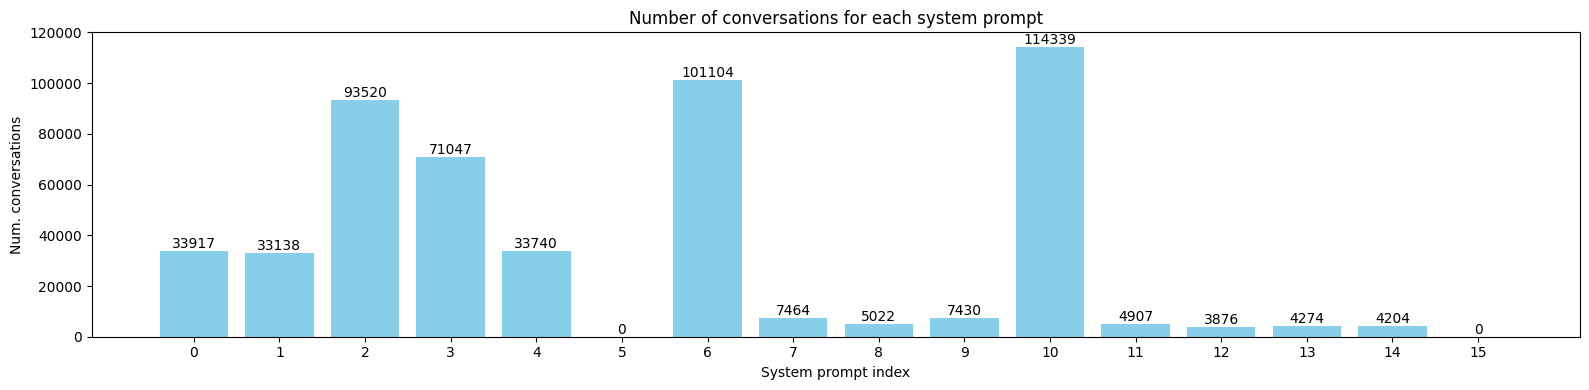

In [ ]:
def plot_system_msgs_count():
    keys = list(system_messages_rev.keys())
    values = [0] * len(keys)
    for conversation in dataset["conversations"]:
        if conversation[0]["from"] == "system":
            system_idx = system_msg_to_id(conversation[0]["value"])
        else:
            system_idx = 0
        values[system_idx] += 1
    plt.figure(figsize=(16, 4))
    bars = plt.bar(keys, values, color='skyblue')
    plt.xlabel('System prompt index')
    plt.ylabel('Num. conversations')
    plt.title('Number of conversations for each system prompt')
    plt.xticks(keys)
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), value,
                 ha='center', va='bottom')
    plt.tight_layout()


plot_system_msgs_count()

Print random conversations from the data set

In [ ]:
def print_random_samples(n_samples:int):
  for i in random.sample(range(len(dataset)), n_samples):
    conversation = dataset["conversations"][i]
    if len(conversation) == 3:
      sys_msg = conversation[0]["value"]
      human_msg = conversation[1]["value"]
      gpt_msg = conversation[2]["value"]
    else:
      sys_msg = id_to_system_msg(1)
      human_msg = conversation[0]["value"]
      gpt_msg = conversation[1]["value"]

    print(f'[SYSTEM]: {sys_msg}\n[HUMAN]: {human_msg}\n[GPT]: {gpt_msg}\n')


print_random_samples(1) # as a toy example we print just a random sample

[SYSTEM]: You are an AI assistant that helps people find information. User will you give you a question. Your task is to answer as faithfully as you can. While answering think step-by-step and justify your answer.
[HUMAN]: Q: Passage: In a deserted car, Michael discovers the body of the man he planted the GPS tracker on and a badge revealing he was an FBI agent. Sabotaging the air conditioning in the train except for the last car, Michael forces all of the remaining passengers into the last car. He realizes another passenger, a musician, killed the FBI agent; he also received the same deal for $100,000, but with instructions to kill Prynne. Michael and the musician fight, at which point the musician is thrown from the train and killed. The real "Prynne" is revealed to be a young girl named Sofia, who is holding incriminating information on powerful people and was to go into witness protection at the final stop of the train. Michael asks Sofia why she did not go to the police. She revea

We then computed some basic statistics about the conversations, like average Q/A lengths and max lengths (important to set properly the max_seq_length accepted by the model not to lose much information during training)

In [ ]:
avg_question_len = human.apply(lambda x: len(x.split())).mean()
avg_answer_len = gpt.apply(lambda x: len(x.split())).mean()

print(f"Average question words: {avg_question_len:.2f}\nAverage answer words: {avg_answer_len:.2f}")

Average question words: 166.44
Average answer words: 98.95


In [ ]:
longest_question = human.apply(lambda x: len(x.split())).max()
longest_answer = gpt.apply(lambda x: len(x.split())).max()

print(f"Longest question: {longest_question} words\nLongest answer: {longest_answer} words")

Longest question: 6310 words
Longest answer: 1038 words


# TOPIC MODELLING

We applied topic modelling to cluster gpt answers in coherent groups in order to find latent topics and decide what subset of the dataset to focus on (to reduce training time and build a specific model).

We started by vectorizing answers using TF-IDF scores.

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.05, min_df=3)
tfidf_answers = vectorizer.fit_transform(gpt)

In [ ]:
feature_names = vectorizer.get_feature_names_out()

Then we treated the problem as a matrix factorization problem, namely we applied **Non-negative Matrix Factorization** to factorize the tfidf_matrix containing associations between gpt-answers and vocabulary into 2 smaller submatrices:

*   answer-topic matrix: represents the per-document topic distribution by associating every answer a relevance score for a certain topic
*   topic-word matrix: represents the per-topic word distribution



In [ ]:
num_topics = 10  # Number of clusters/topics
nmf_model = NMF(n_components=num_topics, init='nndsvd', random_state=42)
asw_topic_matrix = nmf_model.fit_transform(tfidf_answers)

In [ ]:
topic_word_matrix = nmf_model.components_

Then we plot the top words for each topic in order to be able to understand what topics we found.

In [ ]:
# Function to display top words for each topic
def display_topics(H, feature_names, num_top_words):
    for topic_idx, topic in enumerate(H):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Display top 5 words for each topic
display_topics(topic_word_matrix, feature_names, num_top_words=10)

Topic 0:
positive sentiment review tweet movie ii good overall happy film
Topic 1:
hypothesis entailed true woman dog girl boy compare men playing
Topic 2:
water movie option called article work help sentences say big
Topic 3:
negative sentiment review movie tweet dissatisfaction overall bad tone phrases
Topic 4:
man woman wearing shirt sitting walking standing describes young holding
Topic 5:
review product reviewer tone user book recommend customer conveys depicts
Topic 6:
false true paragraph say impossible explanation claim second polarity text
Topic 7:
food restaurant customer rating friendly family riverside coffee near city
Topic 8:
text english language translation words translate translated meaning czech word
Topic 9:
equation sides solve isolate variable terms divide value simplify solution


Now we focus only on one topic.

In [ ]:
topic9 = asw_topic_matrix[:,9] # it seems to contain math related conversations

Let's visualize a bit more the distribution of words

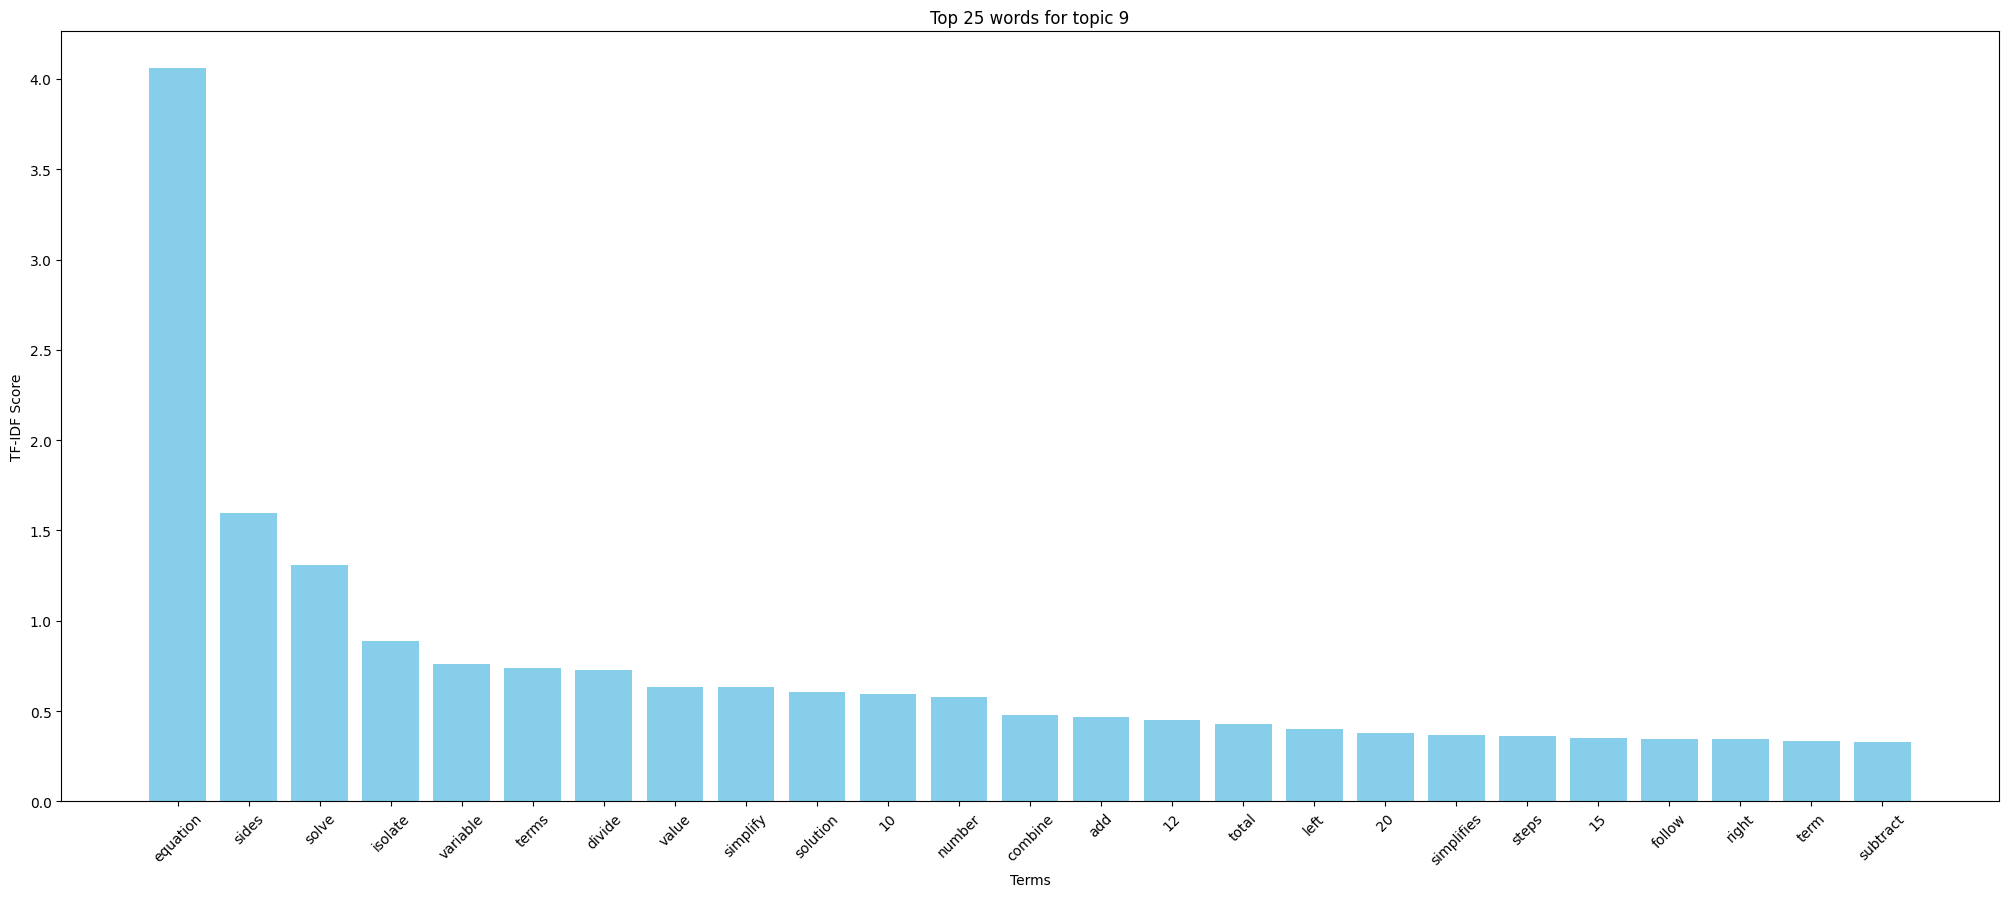

In [ ]:
df = pd.DataFrame({'term': feature_names, 'tfidf': topic_word_matrix[9,:]})
df = df.sort_values(by='tfidf', ascending=False)

# Plot the top 25 terms
plt.figure(figsize=(25, 10))
plt.bar(df['term'].head(25), df['tfidf'].head(25), color='skyblue')
plt.xlabel('Terms')
plt.ylabel('TF-IDF Score')
plt.title('Top 25 words for topic 9')
plt.xticks(rotation=45)
plt.show()

Since it is very probable that an answer is not related to all the found topics, we check what is the percentage of nonzero elements, which correspond to the conversations that have at least a slight relevance to our task.

In [ ]:
np.count_nonzero(topic9)/topic9.shape[0]

0.3156345201184597

Since the topic vector is very sparse, we considered only nonzero components to set a threshold and extract the most relevant conversations. We tried to exploit basic statistics to define the threshold and we selected the one better performing.


*   mean of nonzero elements: too low threshold, is too affected by nonrelevant element and can't guarantee to cut off irrelevant topics.
*   median: robust to outliers, but it granted only a top 50% of elements
*   q-th quantile: improvement with respect to the median returning the top (1-q)% of elements. We selected the top 20% using a quantile of 80-th order





In [ ]:
tau = np.quantile(topic9[np.nonzero(topic9)], q=0.8)
filtered_indices = np.where(topic9 > tau)[0]

Now we check how many elements we have extracted

In [ ]:
filtered_indices.shape

(32699,)

And just to be sure to have extracted coherent data, we plot the conversation with the least score in our subdataset.

In [ ]:
min_relevance_index = np.argmin(topic9[filtered_indices])
print(f"{human[filtered_indices].values[min_relevance_index]}\n{gpt[filtered_indices].values[min_relevance_index]}")

Given the task definition and input, reply with output. In this task, you are given an input list A. You need to extract and sort the unique digits used in the list in ascending order. Return -1 if there is no digit in the list.

['i', '73', '283', 'r', 'i', 'x']
The task is asking you to perform the following steps:

1. Identify the unique digits from the given input list.
2. Sort these unique digits in ascending order.
3. Return the sorted list of unique digits.
4. If there are no digits in the input list, return -1.

Here's how to perform each step:

1. Go through each element in the input list: ['i', '73', '283', 'r', 'i', 'x']
2. For each element, check if it contains a digit. In this case, '73' and '283' contain digits.
3. Extract the unique digits from these elements: 7, 3, 2, 8.
4. Sort the unique digits in ascending order: 2, 3, 7, 8.
5. Return the sorted list of unique digits: [2, 3, 7, 8].

If there were no digits in the input list, you would return -1. In this case, since w

# Model


We investigated several models, either causal LMs or bidirectional ones. Here's a list of the most relevant for our task:

<div align="center">

| Model | Training Time | Performance summary |
|-----------------|-----------------|-----------------|
| **Bert-base**  | ⏳ Very Long | Good at retrieving known information, bad with new examples |
| **Gpt2-base**  | ⏳ Very Long | Poor reasoning capabilities |
| **Tinyllama**  | ⏰ Short               | Moderate reasoning capabilities, regurgitated a lot on the training set|
| **Llama-2**    | ⏰ Short               | Good performance, few regurgitates on seen examples       |
| **Llama-3**    | ⏳ Quite Long                | Moderate reasoning capability, comparable to its previous version.            |
| **Mistral v3** | ⏳ Long           | Not bad but not as accurate as expected |

</div>

In the end, we decided to use the **Llama-2** model because it was perfectly balanced between training time and performance on our task.

In [ ]:
model_name = "llama-2-7b"
custom_model_name = "GOGO_GPT"

This cell is just about deciding if loading our fine-tuned model or downloading the pretrained from unslothAI.

In [ ]:
load_model = input("Load model? (y/n): ").lower() == 'y'
path = f"unsloth/{model_name}" if not load_model else f"{custom_model_name}_llama_4096"

Load model? (y/n): n


We used a FastedLanguageModel instance to dramatically reduce training time using QLoRA.

In [ ]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = path, # "unsloth/tinyllama-bnb-4bit", # "unsloth/tinyllama" for 16bit loading
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

Unsloth: You passed in `unsloth/llama-2-7b` and `load_in_4bit = True`.
We shall load `unsloth/llama-2-7b-bnb-4bit` for 4x faster loading.


config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Currently only supports dropout = 0
    bias = "none",    # Currently only supports bias = "none"
    use_gradient_checkpointing = "unsloth", # @@@ IF YOU GET OUT OF MEMORY - set to True @@@
    random_state = 42069,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


This is one the textual prompt suggested to feed the model both at training and inference time. It is based on a general system prompt and an instruction prompt to specify the input context. Then there are the true input and response (response is provided at training time to improve generation capability but of course not at test time).

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

We formatted the subsampled dataset in order to properly feed the model during training.

In [ ]:
EOS_TOKEN = tokenizer.eos_token

formatted_convs = []
for i in filtered_indices:
  fs = alpaca_prompt.format(system[i], human[i], gpt[i]) + EOS_TOKEN
  if len(tokenizer.tokenize(fs)) < max_seq_length:
    formatted_convs.append(fs)
dataset = Dataset.from_dict({"text": formatted_convs})

Token indices sequence length is longer than the specified maximum sequence length for this model (7867 > 4096). Running this sequence through the model will result in indexing errors


In [ ]:
dataset

Dataset({
    features: ['text'],
    num_rows: 32687
})

We trained using Supervised Fine Tuning Trainer.

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = True, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        num_train_epochs = 1,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 42069, # nice
        output_dir = "outputs",
    ),
)

Generating train split: 0 examples [00:00, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:342: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 9,105 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 39,976,960


Step,Training Loss
1,1.536900
2,1.325200
3,1.400700
4,1.390100
5,1.360200
6,1.294000
7,1.174800
8,1.233500
9,1.308500
10,1.063600


TrainOutput(global_step=60, training_loss=1.0150262693564096, metrics={'train_runtime': 2791.4574, 'train_samples_per_second': 0.172, 'train_steps_per_second': 0.021, 'total_flos': 3.920749211418624e+16, 'train_loss': 1.0150262693564096, 'epoch': 0.052712497254557435})

# Save the last trained model

Most important cell probably :)

(really, Colab made us loose quite a lot good models...)

Press F to pay respect.

In [ ]:
from datetime import datetime

checkpoint_path = f"{custom_model_name}_llama2_2048" #_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"
tokenizer.save_pretrained(checkpoint_path)
model.save_pretrained(checkpoint_path)
print(f"Checkpoint saved at: \'{checkpoint_path}\'")

In [ ]:
gogo_path = f"{custom_model_name}_llama2_4096_"

# Merge to 16bit
if False: model.save_pretrained_merged(gogo_path + "16b", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/" + gogo_path + "16b", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if True: model.save_pretrained_merged(gogo_path + "4b", tokenizer, save_method = "merged_4bit",)
if True: model.push_to_hub_merged("hf/" + gogo_path + "4b", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged(gogo_path + "lora", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/" + gogo_path + "lora", tokenizer, save_method = "lora", token = "")

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf(gogo_path + "16b", tokenizer,)
if False: model.push_to_hub_gguf("hf/" + gogo_path + "16b", tokenizer, token = "")

# Save to 16bit GGUF
if True: model.save_pretrained_gguf(gogo_path + "4b", tokenizer, quantization_method = "f16")
if True: model.push_to_hub_gguf("hf/" + gogo_path + "4b", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf(gogo_path + "lora", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/" + gogo_path + "lora", tokenizer, quantization_method = "q4_k_m", token = "")

# Text chat with GOGO_GPT

In [ ]:
chat_history = ""
qst = input()
while qst.lower().strip() != "paolino":
    chat_history += qst
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference
    chat_encoding = tokenizer(
        alpaca_promptpaolino.format(
          #"You are a highly intelligent and detailed-oriented math assistant. Carefully read the problem and follow a step-by-step approach to provide a very accurate and coherent answer. Ensure to show all steps and explain your reasoning at each stage.", # instruction
          "You are a math assistant which is capable of solving numerical problems. Provide a very accurate and coherent answer.", # instruction
          chat_history, # input
          "", # output - leave this blank for generation!
      ), return_tensors="pt").to(device)

    text_streamer = TextStreamer(tokenizer, skip_prompt= True, skip_special_tokens=True)
    resp_ids = model.generate(**chat_encoding, streamer = text_streamer, max_new_tokens = 64, do_sample=True, temperature=0.1, top_k=0, pad_token_id = tokenizer.pad_token_id, repetition_penalty = 2.0)
    output = tokenizer.decode(resp_ids[0, chat_encoding.input_ids.size(1):])
    chat_history += "\n\n### Response:\n" + output + "\n\n### Input:\n"
    qst = input()

2*3
The correct solution for this problem would be 6 (the product).
Who are you
I am [name], your friendly Ai Assistant who can help solve any mathematical question or provide information on various topics! I'm always here to assist in making sense out complex concepts so don’t hesitate if there something unclear about what we discussed earlier today - just ask away :) Let me know how else
paolino


# Model benchmarking

We now make some experiments to compare our fine tuning with pretrained models, like we visualize results and compute some statistics of accuracy.

We want to evaluate the perplexity of our models when facing a math question.

In [ ]:
def perplexity_metric(model, input_encoding):
  cross_entropy = model(input_encoding, labels=input_encoding).loss
  ppl = torch.exp(cross_entropy)
  return ppl.item()

## GOGO_GPT vs GPT2-base

In [ ]:
model_name = "gpt2"

In [ ]:
gpt2 = AutoModelForCausalLM.from_pretrained(model_name, device_map=device)
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
gpt2_streamer = TextStreamer(gpt2_tokenizer, skip_prompt= True)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2 answers be like:

In [ ]:
sys_prompt = "You're about to get most probably a math question. Provide a correct answer and explain, if necessary, how you got to the solution."
qst = input()
input_ids = gpt2_tokenizer.encode(sys_prompt+qst, return_tensors='pt')

with torch.no_grad():
  gpt2.generate(input_ids, streamer = gpt2_streamer, max_new_tokens = 32, do_sample=True, temperature=0.1, top_k=0, pad_token_id = gpt2_tokenizer.eos_token_id, repetition_penalty = 2.0)

2+2=?

I'm not sure what this means for your problem but I think it's important that we understand why some people are so quick to assume they can solve problems


Let's see its perplexity.

In [ ]:
gpt_perplexity = perplexity_metric(gpt2,input_ids)

print(gpt_perplexity)

54.42799377441406


GOGOGPT sounds better:

In [ ]:
qst = input()
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
qst_encoding = tokenizer(
        alpaca_prompt.format(
          #"You are a highly intelligent and detailed-oriented math assistant. Carefully read the problem and follow a step-by-step approach to provide a very accurate and coherent answer. Ensure to show all steps and explain your reasoning at each stage.", # instruction
          "You're about to get most probably a math question. Provide a correct answer and explain, if necessary, how you got to the solution.",
          qst, # input
          "", # output - leave this blank for generation!
      ), return_tensors="pt").to(device)
text_streamer = TextStreamer(tokenizer, skip_prompt= True, skip_special_tokens=True)
resp_ids = model.generate(**qst_encoding, streamer = text_streamer, max_new_tokens = 32, do_sample=True, temperature=0.1, top_k=0, pad_token_id = tokenizer.pad_token_id, repetition_penalty = 2.0)

2+2
The sum of 3 numbers can be calculated by adding their values together as follows - (1) + (-5). The result will then become (+4),


In [ ]:
gogo_perplexity = perplexity_metric(model,resp_ids)

print(gogo_perplexity)

6.492988109588623


And let's see the Llama2 model pretrained without fine tuning.

In [ ]:
model_name = "unsloth/llama-2-7b"

In [ ]:
llama2, llama2_tokenizer = FastLanguageModel.from_pretrained(
        model_name = model_name,
        max_seq_length = 1024,
        dtype = None,
        load_in_4bit = True,
    )
FastLanguageModel.for_inference(llama2)

Unsloth: You passed in `unsloth/llama-2-7b` and `load_in_4bit = True`.
We shall load `unsloth/llama-2-7b-bnb-4bit` for 4x faster loading.


config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [ ]:
qst = "You're about to get most probably a math question. Provide a correct answer and explain, if necessary, how you got to the solution. "+ input()

inputs = llama2_tokenizer(qst,return_tensors = "pt").to("cuda")

from transformers import TextStreamer
llama2_streamer = TextStreamer(llama2_tokenizer, skip_prompt= True, skip_special_tokens=True)
resp_ids = llama2.generate(**inputs, streamer = llama2_streamer, max_new_tokens = 32, do_sample=True, temperature=0.1, top_k=0, pad_token_id = llama2_tokenizer.pad_token_id, repetition_penalty = 2.0)

2+2=?

The first thing that comes into my mind is: "I don’t know". I have no idea what this person wants from me or why he/


In [ ]:
llama2_perplexity = perplexity_metric(llama2,resp_ids)

print(llama2_perplexity)

11.534558296203613


# Adding some conversation with Chat GPT 4o

We tried to add some conversations made by us with Chat GPT 4o to see if we could get any improvement

In [ ]:
human_new = []
gpt_new = []

human_new.append("What is the square root of 169?")
gpt_new.append("The square root of 169 is 13.")
human_new.append("What is the integral of ln(x)/x?")
gpt_new.append("""The integral of ln(x)/x with respect to x is a classic integral in calculus. It doesn't have an elementary antiderivative (a solution in terms of elementary functions), but it can be expressed in terms of a special function called the logarithmic integral, denoted as Li(x).

So, the integral of ln(x)/x can be represented as:

∫(ln(x)/x) dx = Li(x) + C

Where C is the constant of integration.""")
human_new.append("What is the integral of 1/x?")
gpt_new.append("""The integral of \( \frac{1}{x} \) with respect to \( x \) is the natural logarithm of the absolute value of \( x \), plus a constant of integration:

\[ \int \frac{1}{x} \, dx = \ln|x| + C \]

Where \( C \) is the constant of integration.""")
human_new.append("And which is the derivative of ln|x| + C?")
gpt_new.append("""The derivative of \( \ln|x| + C \) with respect to \( x \) is \( \frac{1}{x} \), assuming \( x \neq 0 \). This is a consequence of the chain rule of differentiation and the fact that the derivative of \( \ln|x| \) is \( \frac{1}{x} \). The constant \( C \) does not affect the derivative and thus disappears when differentiating.""")
human_new.append("Do you like math?")
gpt_new.append("""Absolutely! Math is like a puzzle waiting to be solved, with its own elegant logic and patterns. It's fascinating how it's woven into the fabric of the universe, governing everything from the motions of celestial bodies to the behavior of subatomic particles. Plus, there's something deeply satisfying about finding the solution to a challenging problem or proving a theorem. Math is beautiful in its own way!""")
human_new.append("What is the limit of sin(10x)/10x?")
gpt_new.append("""To find the limit of \( \frac{\sin(10x)}{10x} \) as \( x \) approaches 0, you can use L'Hôpital's Rule, which states that if the limit of a quotient of two functions is in an indeterminate form (\( \frac{0}{0} \) or \( \frac{\infty}{\infty} \)), and both the numerator and the denominator approach zero (or infinity), then the limit of the quotient is equal to the limit of the derivative of the numerator divided by the derivative of the denominator.

So, let's apply L'Hôpital's Rule:

\[ \lim_{x \to 0} \frac{\sin(10x)}{10x} = \lim_{x \to 0} \frac{\frac{d}{dx}\sin(10x)}{\frac{d}{dx}(10x)} \]

Taking derivatives:

\[ = \lim_{x \to 0} \frac{10\cos(10x)}{10} \]

\[ = \lim_{x \to 0} \cos(10x) \]

Now, as \( x \) approaches 0, \( 10x \) approaches 0 as well, so \( \cos(10x) \) approaches \( \cos(0) = 1 \).

Therefore, the limit is \( 1 \).""")
human_new.append("And the limit of sin(5x)/10x?")
gpt_new.append("""To find the limit of \( \frac{\sin(5x)}{10x} \) as \( x \) approaches 0, we can again use L'Hôpital's Rule since it's in an indeterminate form (\( \frac{0}{0} \)).

So, let's apply L'Hôpital's Rule:

\[ \lim_{x \to 0} \frac{\sin(5x)}{10x} = \lim_{x \to 0} \frac{\frac{d}{dx}\sin(5x)}{\frac{d}{dx}(10x)} \]

Taking derivatives:

\[ = \lim_{x \to 0} \frac{5\cos(5x)}{10} \]

\[ = \lim_{x \to 0} \frac{\cos(5x)}{2} \]

Now, as \( x \) approaches 0, \( 5x \) also approaches 0, so \( \cos(5x) \) approaches \( \cos(0) = 1 \).

Therefore, the limit is \( \frac{1}{2} \).""")
human_new.append("Explain me why e^i*pi = -1")
gpt_new.append("""The equation \( e^{i\pi} = -1 \) is a fundamental result in mathematics, often referred to as Euler's formula. Let's break it down:

1. **Euler's Formula**: Euler's formula states that \( e^{ix} = \cos(x) + i\sin(x) \), where \( i \) is the imaginary unit, defined as \( i = \sqrt{-1} \).

2. **Substitution**: If we substitute \( \pi \) for \( x \) in Euler's formula, we get:

\[ e^{i\pi} = \cos(\pi) + i\sin(\pi) \]

3. **Trigonometric Identities**: Using trigonometric identities, we know that \( \cos(\pi) = -1 \) and \( \sin(\pi) = 0 \), since cosine is the x-coordinate and sine is the y-coordinate on the unit circle at angle \( \pi \).

4. **Result**: Substituting these values into the equation, we get:

\[ e^{i\pi} = -1 + i(0) = -1 \]

So, \( e^{i\pi} \) indeed equals \( -1 \).

This result is profound because it connects five of the most fundamental constants in mathematics: \( e \), \( i \), \( \pi \), \( 1 \), and \( 0 \), into a single equation. It's a beautiful example of the unity of seemingly disparate areas of mathematics: exponential functions, trigonometry, and complex numbers.""")
# human_new.append("go" * 5)
# gpt_new.append("go" * 69)

In [ ]:
formatted_convs_new = []
for i in len(human_new):
  formatted_convs_new.append(alpaca_prompt.format("", human_new[i], gpt_new[i]) + EOS_TOKEN)
dataset_new = Dataset.from_dict({"text": formatted_convs_new})

# Voice chat with GOGO_GPT

In [ ]:
!pip install -U openai-whisper -q
!pip install numpy scipy librosa unidecode inflect -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
import whisper, scipy
from IPython.display import Audio

In [ ]:
speech_to_text_model = whisper.load_model("base")

tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to(device)
tacotron2.eval()
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

100%|███████████████████████████████████████| 139M/139M [00:14<00:00, 10.1MiB/s]
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/text/__init__.py:74: SyntaxWarning: "is not" with a l

Here we define two simple methods for implementing speech-to-text and text-to-speech

In [ ]:
def speech_to_text():
    audio, sr = get_audio()
    scipy.io.wavfile.write('recording.wav', sr, audio)
    return speech_to_text_model.transcribe("recording.wav")["text"]

def text_to_speech(text):
    sequences, lengths = utils.prepare_input_sequence([text])
    with torch.no_grad():
      mel, _, _ = tacotron2.infer(sequences, lengths)
    with torch.no_grad():
      audio = waveglow.infer(mel)
    audio_numpy = audio[0].data.cpu().numpy()
    display(Audio(audio_numpy, rate=22050, autoplay=True))

# Let's trying to make it speak
text_to_speech("Hello, nice to meet you!")

Reimplement the chatbot based only on voice

In [ ]:
chat_history = ""
qst = speech_to_text()
for i in range(2):
    print(qst)
    chat_history += qst
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference
    chat_encoding = tokenizer(
        alpaca_prompt.format(
          #"You are a highly intelligent and detailed-oriented math assistant. Carefully read the problem and follow a step-by-step approach to provide a very accurate and coherent answer. Ensure to show all steps and explain your reasoning at each stage.", # instruction
          "You are a math assistant which is capable of solving numerical problems. Provide a very accurate and coherent answer.", # instruction
          chat_history, # input
          "", # output - leave this blank for generation!
      ), return_tensors="pt").to(device)

    text_streamer = TextStreamer(tokenizer, skip_prompt= True, skip_special_tokens=True)
    resp_ids = model.generate(**chat_encoding, streamer = text_streamer, max_new_tokens = 32, do_sample=True, temperature=0.1, top_k=0, pad_token_id = tokenizer.pad_token_id, repetition_penalty = 2.0)
    output = tokenizer.decode(resp_ids[0, chat_encoding.input_ids.size(1):])
    text_to_speech(output)
    chat_history += "\n\n### Response:\n" + output + "\n\n### Input:\n"
    qst = speech_to_text()

 Hi, how are you?
Hi! I'm doing great today - thanks for asking :) Now let me solve this problem step-by=step to help understand it better... 1



Let x be equal in value (not variable) as follows;  20 * (-35 / +49)... now we can simplify things by


# Test with different math-based dataset

We found the Mathematics database of Huggingface and we wanted to try to finetune with a specific dataset to see how much can improve.

In [ ]:
dataset = load_dataset("math_dataset", "algebra__linear_1d", split="train")

Generating train split:   0%|          | 0/1999998 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# create a dataframe from the dataset
df_math = pd.DataFrame(dataset)

# extract and separate messages in the 3 categories
question = df_math.apply(lambda row: row[0], axis=1)
answer = df_math.apply(lambda row: row[1], axis=1)

Print random conversations from the data set

In [ ]:
for i in random.sample(range(len(dataset)), 5):
    print(f"[QUESTION]: {question[i]}\n[ANSWER]: {answer[i]}\n")

[QUESTION]: b'Solve -12409 + 433 - 1778 = -529*f for f.\n'
[ANSWER]: b'26\n'

[QUESTION]: b'Solve 136*o + 128*o + 528 = 0 for o.\n'
[ANSWER]: b'-2\n'

[QUESTION]: b'Solve -29*j + 16 = -37*j for j.\n'
[ANSWER]: b'-2\n'

[QUESTION]: b'Solve 1018 = -250*n - 482 for n.\n'
[ANSWER]: b'-6\n'

[QUESTION]: b'Solve 6 = 14*w - 12*w for w.\n'
[ANSWER]: b'3\n'



Create and fine tune the model following the same schema.

In [ ]:
load_model = input("Load model? (y/n): ").lower() == 'y'
model_name = "llama-2-7b"
# model_name = "tinyllama-bnb-4bit"
# model_name = "llama-3-8b-bnb-4bit"
custom_model_name = "GOGO_GPT_dataset2"
path = f"unsloth/{model_name}" if not load_model else f"{custom_model_name}_llamanontiny"

Load model? (y/n): y


In [ ]:
max_seq_length = 4098 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = path, #"unsloth/tinyllama-bnb-4bit", # "unsloth/tinyllama" for 16bit loading
    max_seq_length = max_seq_length,
    dtype =  dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Currently only supports dropout = 0
    bias = "none",    # Currently only supports bias = "none"
    use_gradient_checkpointing = "unsloth", # @@@ IF YOU GET OUT OF MEMORY - set to True @@@
    random_state = 42069,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

In [ ]:
EOS_TOKEN = tokenizer.eos_token

formatted_convs = []
for i in range(len(question)):
  formatted_convs.append(alpaca_prompt.format("You're about to get most probably a math question. Provide a correct answer and explain, if necessary, how you got to the solution.", question[i], answer[i]) + EOS_TOKEN)
dataset = Dataset.from_dict({"text": formatted_convs})

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = True, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        num_train_epochs = 1,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 42069,
        output_dir = "outputs",
    ),
)

In [ ]:
torch.cuda.empty_cache()
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \   /|    Num examples = 117,736 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 39,976,960

TrainOutput(global_step=60, training_loss=0.5079457586010298, metrics={'train_runtime': 2404.5206, 'train_samples_per_second': 0.2, 'train_steps_per_second': 0.025, 'total_flos': 3.920749211418624e+16, 'train_loss': 0.5079457586010298, 'epoch': 0.0040769178501053206})


In [ ]:
from datetime import datetime

checkpoint_path = f"{custom_model_name}_llama_algebra" #_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"
tokenizer.save_pretrained(checkpoint_path)
model.save_pretrained(checkpoint_path)
print(f"Checkpoint saved at: \'{checkpoint_path}\'")

Checkpoint saved at: 'GOGO_GPT_dataset2_llama_algebra'


Let's see how well it performs.

In [ ]:
chat_history = ""
qst = input()
while qst.lower().strip() != "paolino":
    chat_history += qst
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference
    chat_encoding = tokenizer(
        alpaca_prompt.format(
          "You are a math assistant which is capable of solving numerical problems. Provide a very accurate and coherent answer.", # instruction
          chat_history, # input
          "", # output - leave this blank for generation!
      ), return_tensors="pt").to(device)

    text_streamer = TextStreamer(tokenizer, skip_prompt= True, skip_special_tokens=True)
    resp_ids = model.generate(**chat_encoding, streamer = text_streamer, max_new_tokens = 32, do_sample=True, temperature=0.1, top_k=0, pad_token_id = tokenizer.pad_token_id, repetition_penalty = 2.0)
    output = tokenizer.decode(resp_ids[0, chat_encoding.input_ids.size(1):])
    chat_history += "\n\n### Response:\n" + output + "\n\n### Input:\n"
    qst = input()

Tell me what's 5 +5?
10
paolino


In [ ]:
new_gogo_perplexity = perplexity_metric(model,resp_ids)

print(new_gogo_perplexity)

8.821292877197266
